In [2]:
import pandas as pd

data_directory = '../data/'

df = pd.read_csv(data_directory + 'fuel_train.csv')

df.head()

,Year,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,COEMISSIONS
0,2000,VOLKSWAGEN,GTI,COMPACT,2.0,4,M5,X,11.2,228
1,2000,DODGE,DAKOTA 4X4,PICKUP TRUCK - STANDARD,4.7,8,M5,X,18.8,382
2,2000,GMC,C1500 SIERRA,PICKUP TRUCK - STANDARD,4.8,8,M5,X,18.9,373
3,2000,FORD,F150 4X4,PICKUP TRUCK - STANDARD,4.6,8,A4,X,18.5,380
4,2000,FORD,F150 4X4,PICKUP TRUCK - STANDARD,4.2,6,A4,X,17.3,359


### Check for missing values:

In [3]:
import numpy as np
# check for missing values

np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

no missing values in the data, so no row removal or column estimation required right now

### Encode Categorical variables

type, name of origin and destination features are categorical. Need to encode them with numerical values to make them comprehensible to the algorithms i will be coding.

Methods:
1) Ordinal coding - for known relationship between categories - not our case
2) One hot encoding - no relationship between categories - reflects our case
3) Learned embedding - combines both

Since there is no ordered relationship between the categories, using one hot encoding makes.

Downside: too many columns are generated

In [4]:
print(df['MAKE'].nunique())
print(df['MODEL'].nunique())

print(df['TRANSMISSION'].unique())

print(df['VEHICLE CLASS'].nunique())
print(df['MODEL'].nunique())

print(df['FUEL'].unique())

print(df['Year'].nunique())

# number of rows in the frame
print(df.shape[0])

36
292
['M5' 'A4' 'AS4' 'A5' 'M6' 'A3' 'AS5']
14
292
['X' 'Z' 'D' 'N' 'E']
1
511


it seems feasible to use one hot encoding for transmission and fuel

What about the number of categories per class and how many categorical variables do each have?

In [139]:
print(df.head())

   Year    MAKE           MODEL VEHICLE CLASS  ENGINE SIZE  CYLINDERS  \
0  2000     BMW            740i      MID-SIZE          4.4          8   
1  2000     GMC  C1500 YUKON XL           SUV          5.3          8   
2  2000   MAZDA             MPV       MINIVAN          2.5          6   
3  2000   DODGE    RAM 1500 VAN   VAN - CARGO          3.9          6   
4  2000  SATURN            SC #    SUBCOMPACT          1.9          4   

  TRANSMISSION FUEL  FUEL CONSUMPTION  COEMISSIONS   
0           A5    Z              15.4           308  
1           A4    X              18.9           391  
2           A4    X              15.2           313  
3           A3    X              17.6           377  
4           M5    X              10.3           202  


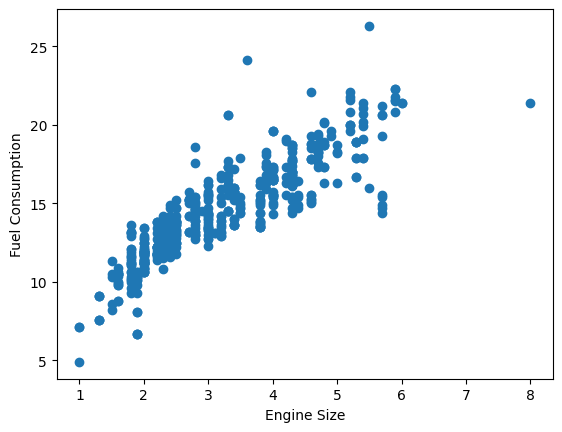

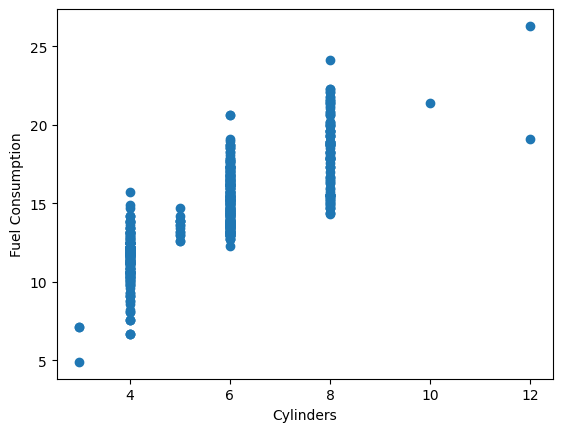

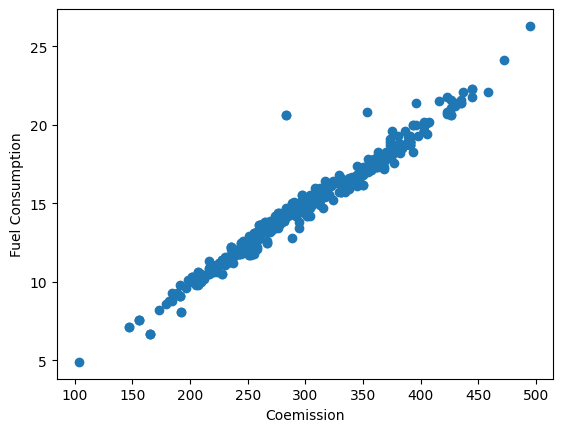

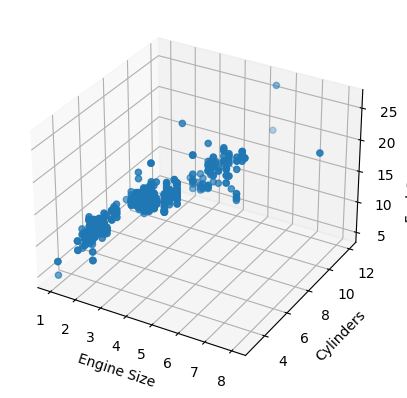

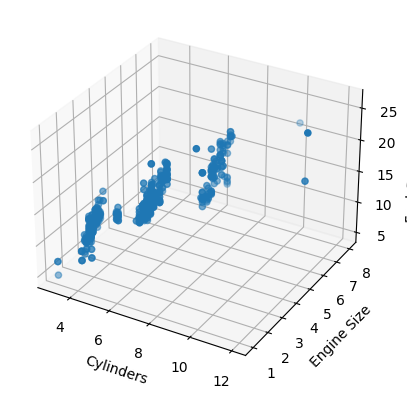

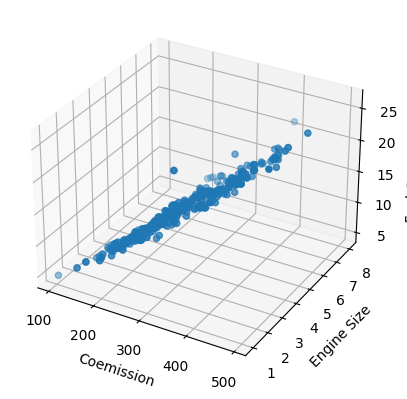

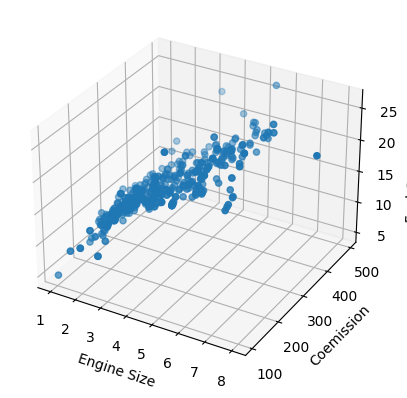

In [5]:
import matplotlib.pyplot as plt

plt.scatter(df['ENGINE SIZE'], df['FUEL CONSUMPTION'])
plt.xlabel('Engine Size')
plt.ylabel('Fuel Consumption')
plt.show()

plt.scatter(df['CYLINDERS'], df['FUEL CONSUMPTION'])
plt.xlabel('Cylinders')
plt.ylabel('Fuel Consumption')
plt.show()

plt.scatter(df['COEMISSIONS '], df['FUEL CONSUMPTION'])
plt.xlabel('Coemission')
plt.ylabel('Fuel Consumption')
plt.show()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['ENGINE SIZE'], df['CYLINDERS'], df['FUEL CONSUMPTION'])
ax.set_xlabel('Engine Size')
ax.set_ylabel('Cylinders')
ax.set_zlabel('Fuel Consumption')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['CYLINDERS'], df['ENGINE SIZE'], df['FUEL CONSUMPTION'])
ax.set_xlabel('Cylinders')
ax.set_ylabel('Engine Size')
ax.set_zlabel('Fuel Consumption')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['COEMISSIONS '], df['ENGINE SIZE'], df['FUEL CONSUMPTION'])
ax.set_xlabel('Coemission')
ax.set_ylabel('Engine Size')
ax.set_zlabel('Fuel Consumption')

plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['ENGINE SIZE'], df['COEMISSIONS '], df['FUEL CONSUMPTION'])
ax.set_xlabel('Engine Size')
ax.set_ylabel('Coemission')
ax.set_zlabel('Fuel Consumption')

plt.show()

Engine Size has a fairly linear relationship with fuel consumption

Cylinders does not give much meaningful information about the fuel consumption

['X' 'Z' 'D' 'N' 'E']
{3, 4, 13, 23, 25}


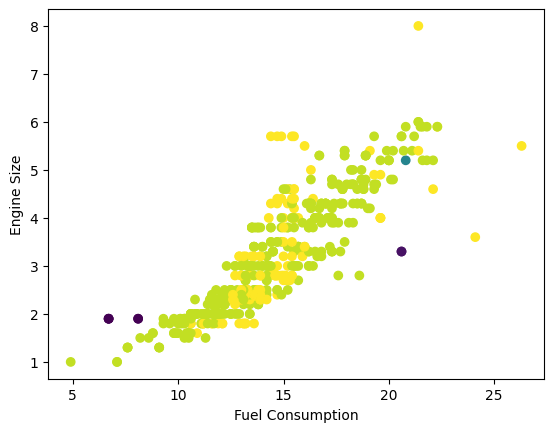

['COMPACT' 'PICKUP TRUCK - STANDARD' 'SUBCOMPACT' 'SUV' 'VAN - PASSENGER'
 'PICKUP TRUCK - SMALL' 'FULL-SIZE' 'VAN - CARGO' 'MID-SIZE' 'MINIVAN'
 'TWO-SEATER' 'STATION WAGON - MID-SIZE' 'MINICOMPACT'
 'STATION WAGON - SMALL']
{513, 1379, 637, 454, 682, 1580, 688, 465, 1522, 755, 602, 953, 1306, 189}


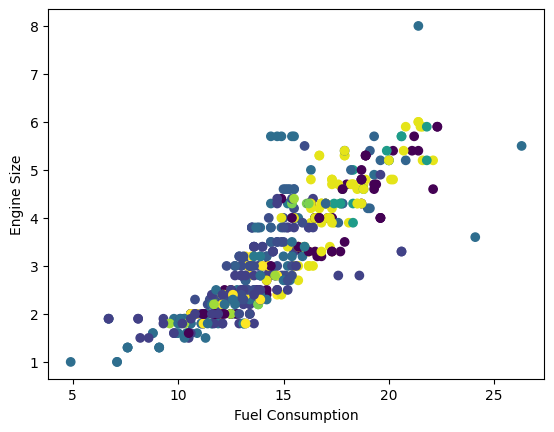

In [6]:
fuel_colors = df['FUEL'].apply(lambda x: ord(x) - ord('A'))

print(df['FUEL'].unique())
print(set(fuel_colors))


plt.scatter(df['FUEL CONSUMPTION'], df['ENGINE SIZE'], c=fuel_colors, cmap='viridis')
plt.xlabel('Fuel Consumption')
plt.ylabel('Engine Size')
plt.show()

# assign each vehicle class a color, considering the feature value is a string

vehicle_class_colors = df['VEHICLE CLASS'].apply(lambda x: sum([ord(x[i]) for i in range(len(x))]) - ord('A'))

print(df['VEHICLE CLASS'].unique())
print(set(vehicle_class_colors))


plt.scatter(df['FUEL CONSUMPTION'], df['ENGINE SIZE'], c=vehicle_class_colors, cmap='viridis')
plt.xlabel('Fuel Consumption')
plt.ylabel('Engine Size')
plt.show()

There's no visible inference that can be made from the fuel type or vechicle class as they are quite spread out over fuel consumption values.

There are not enough training points available to claim that all 'blue' fuel types will have high fuel consumption

In [29]:
list(df['FUEL'].unique())

['X', 'Z', 'D', 'N', 'E']

Since there exists a linear relationship between engine size and fuel consumption, it makes sense to use linear regression by fitting on the engine size values with the target as fuel consumption

408
103


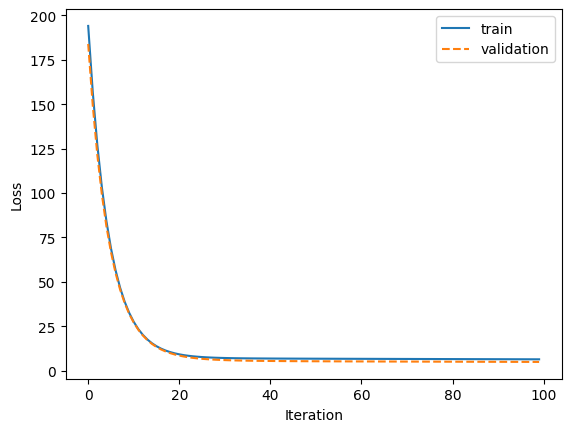

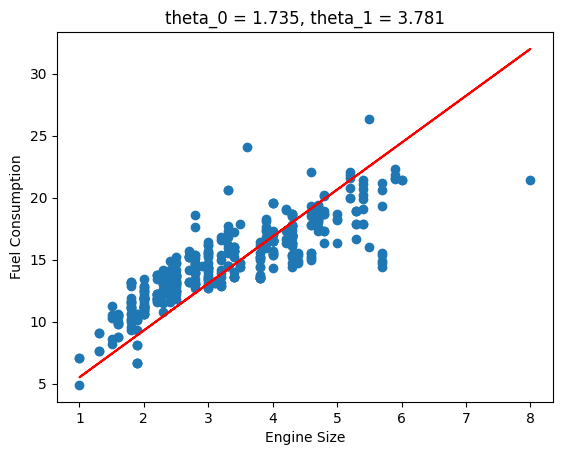

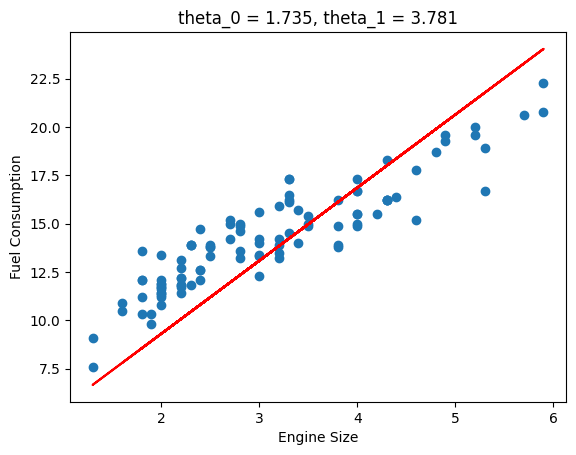

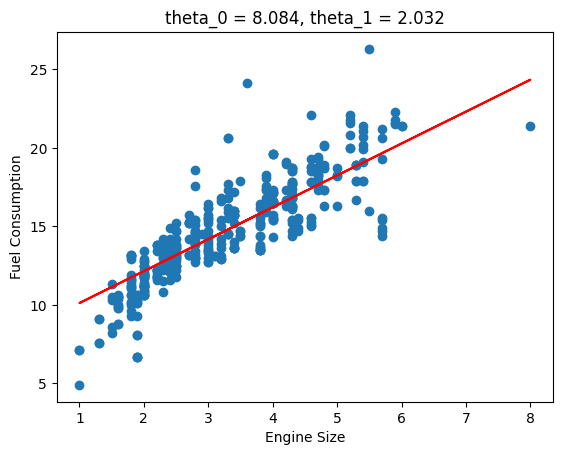

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class LinearRegression:
    def __init__(self, alpha=0.0001, num_iterations=30):
        self.alpha = alpha
        self.num_iterations = num_iterations
        # using a single feature for my prediction as indicated in my data exploration
        self.theta_0 = 0
        self.theta_1 = 0
        self.cost_history = []

    def pred(self, feat_val):
        return self.theta_0 + self.theta_1 * feat_val

    def cost(self, X_data, Y_true):
        mse = 0
        for i in range(len(X_data)):
            mse += (self.pred(X_data.iloc[i]) - Y_true.iloc[i])**2
        # return mean of the squared errors
        return mse / len(X_data)

    def calc_grad(self,X,Y):
        # loss = sigma((y_n - (theta_0 + theta_1*x_n))^2)
        # taking partial derivatives of the loss function above with respect to theta_0 and theta_1
        grad_theta1 = sum([-2*X[i]*(Y[i] - (self.theta_0 + self.theta_1*X[i])) for i in range(len(X))])
        grad_theta0 = sum([-2*(Y[i] - (self.theta_0 + self.theta_1*X[i])) for i in range(len(X))])
        self.theta_0 = self.theta_0 - self.alpha*grad_theta0
        self.theta_1 = self.theta_1 - self.alpha*grad_theta1

    def fit(self, X_train, y_train,X_validation,y_validation):
        self.theta_0 = np.random.rand(1)[0]
        self.theta_1 = np.random.rand(1)[0]
        for i in range(self.num_iterations):
            train_loss = self.cost(X_train, y_train)
            validation_loss = self.cost(X_validation,y_validation)
            self.cost_history.append((train_loss, validation_loss))
            self.calc_grad(X_train, y_train)

    def loss_plot(self):
        train_loss = [self.cost_history[i][0] for i in range(len(self.cost_history))]
        validation_loss = [self.cost_history[i][1] for i in range(len(self.cost_history))]
        plt.plot(train_loss,label='train')
        plt.plot(validation_loss, label='validation', linestyle='--')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plotline(self,X,Y):
        plt.scatter(X, Y)
        plt.plot(X, self.predict(X), color='red')
        plt.xlabel('Engine Size')
        plt.ylabel('Fuel Consumption')
        plt.title(f'theta_0 = {self.theta_0:.3f}, theta_1 = {self.theta_1:.3f}')
        plt.show()

    def predict(self,X):
        # TODO: ask if X is going to be a dataframe/list or a single feature vector
        predictions = [self.pred(x) for x in X]
        return predictions

# filtered the datafram to remove rows with missing engine size or fuel consumption values
df = df.sample(frac=1).reset_index(drop=True)

df = df.dropna(subset=['ENGINE SIZE', 'FUEL CONSUMPTION'])

X = df['ENGINE SIZE']
y = df['FUEL CONSUMPTION']

X_train = X[:int(0.8*len(X))]
y_train = y[:int(0.8*len(y))]


X_validation = X[int(0.8*len(X)):]
y_validation = y[int(0.8*len(y)):]

print(len(X_train))
print(len(X_validation))


linear_regressor = LinearRegression(alpha=0.00001, num_iterations=100)

linear_regressor.fit(X_train, y_train,X_validation,y_validation)

linear_regressor.loss_plot()

linear_regressor.plotline(X_train, y_train)
linear_regressor.plotline(X_validation, y_validation)

# with open('../models/regression_model1.pkl','wb') as f:
#     pickle.dump(linear_regressor,f)

with open('../models/regression_model1.pkl', 'rb') as f:
    linear_regressor_load = pickle.load(f)

linear_regressor_load.plotline(X_train, y_train)

In [175]:
print(linear_regressor_load.cost_history)

[(179.2453552973196, 188.53946777731613), (160.91094794120843, 169.04149285137433), (144.48008501249802, 151.57400824203685), (129.7551352742371, 135.92586874226708), (116.55898611553818, 121.90786890384129), (104.73291325062821, 109.35046421306227), (94.1346715916788, 98.1017289131816), (84.63678433254478, 88.02552590135589), (76.1250096645951, 78.99986667927008), (68.4969666823804, 70.91544162297222), (61.660903951605725, 63.67430288648999), (55.534595927806784, 57.18868409007842), (50.04435395191691, 51.37994258957678), (45.12413992702952, 46.177611598116236), (40.71477201571165, 41.51855075306719), (36.763212804033785, 37.34618490553709), (33.22193137039659, 33.6098219711764), (30.048331586148766, 30.26404163228922), (27.2042397716289, 27.268147533720274), (24.655445545185092, 24.58567637895088), (22.371290342528862, 22.18395801747961), (20.32429865715713, 20.033721228118758), (18.48984756642111, 18.10874045268837), (16.845870568320066, 16.385519227349665), (15.372592166784552, 14.

Implementation of multiple linear regression with both engine size and coemissions

408
103


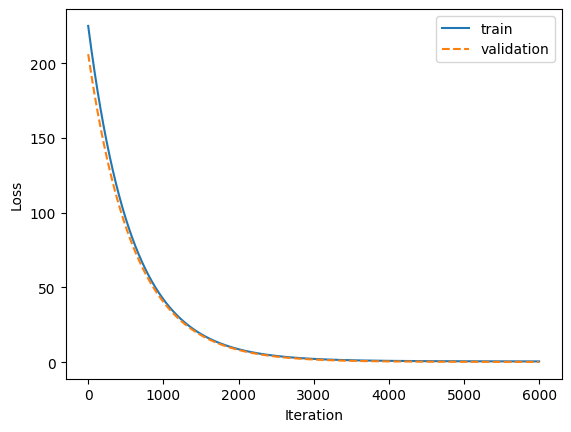

Training Validation MSE: (0.5420693878729681, 0.1919183108897514)


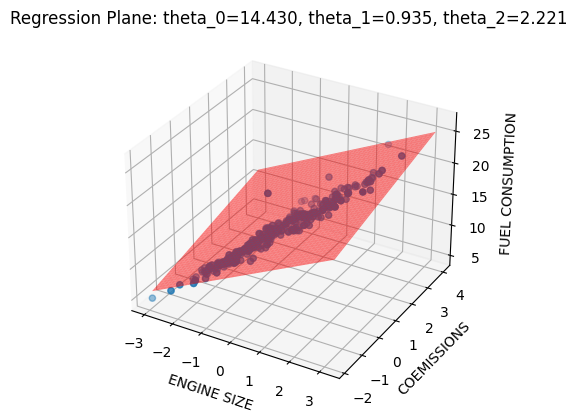

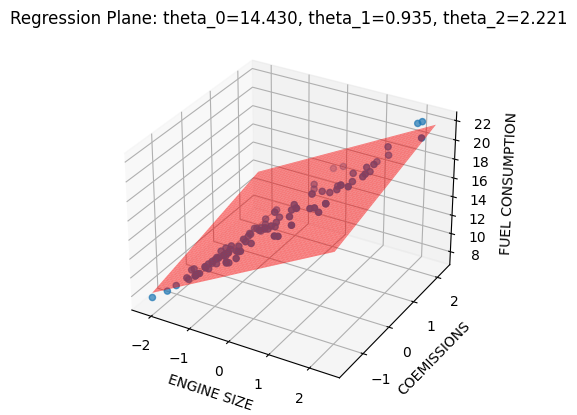

In [8]:
# implement regression model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class LinearRegression:
    def __init__(self, alpha=0.0001, num_iterations=30):
        self.alpha = alpha
        self.num_iterations = num_iterations
        # theta is a vector of theta_0, theta_1 ... theta_n for n number of features
        self.theta = []
        self.cost_history = []

    def pred(self, X):
        # X is a single tuple
        return self.theta[0] + sum([self.theta[i+1]*X[i] for i in range(len(X))])

    def cost(self, X_data, Y_true):
        mse = 0
        for i in range(len(X_data)):
            mse += (self.pred(X_data.iloc[i]) - Y_true.iloc[i])**2
        # return mean of the squared errors
        return mse / len(X_data)

    def calc_grad(self,X,Y):
        # loss = sigma((y_n - (theta_0 + theta_1*x_n))^2)
        # taking partial derivatives of the loss function above with respect to theta_0 and theta_1
        grad_theta0 = sum([-2*(Y[i] - (self.theta[0] + sum([self.theta[k+1]*X.iloc[i][k] for k in range(X.shape[1])]))) for i in range(len(X))])
        self.theta[0] = self.theta[0] - self.alpha*grad_theta0
        for i in range(X.shape[1]):
            # gradcur_theta = sum([-2*(Y[i] - (self.theta_0 + self.theta_1*X[i])) for i in range(len(X))])
            # calculate the gradient of the loss function with respect to theta_{i+1}
            gradcur_theta = sum([-2*X.iloc[j][i]*(Y[j] - (self.theta[0] + sum([self.theta[k+1]*X.iloc[j][k] for k in range(X.shape[1])]))) for j in range(len(X))])
            self.theta[i+1] = self.theta[i+1] - self.alpha*gradcur_theta

    def fit(self, X_train, y_train,X_validation,y_validation):
        self.theta.append(0.0)
        for i in range(X.shape[1]):
            # self.theta.append(np.random.rand(1)[0])
            self.theta.append(0.0)

        for i in range(self.num_iterations):
            train_loss = self.cost(X_train, y_train)
            validation_loss = self.cost(X_validation,y_validation)
            self.cost_history.append((train_loss, validation_loss))
            self.calc_grad(X_train, y_train)

    def loss_plot(self):
        train_loss = [self.cost_history[i][0] for i in range(len(self.cost_history))]
        validation_loss = [self.cost_history[i][1] for i in range(len(self.cost_history))]
        plt.plot(train_loss,label='train')
        plt.plot(validation_loss, label='validation', linestyle='--')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plotline(self, X, Y):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X['COEMISSIONS '], X['ENGINE SIZE'], Y)
        x1 = np.linspace(X['COEMISSIONS '].min(), X['COEMISSIONS '].max(), 100)
        x2 = np.linspace(X['ENGINE SIZE'].min(), X['ENGINE SIZE'].max(), 100)
        x1, x2 = np.meshgrid(x1, x2)
        z = self.theta[0] + self.theta[1] * x2 + self.theta[2] * x1
        ax.plot_surface(x1, x2, z, color='red', alpha=0.5)
        ax.set_xlabel('ENGINE SIZE')
        ax.set_ylabel('COEMISSIONS')
        ax.set_zlabel('FUEL CONSUMPTION')
        plt.title(f'Regression Plane: theta_0={self.theta[0]:.3f}, theta_1={self.theta[1]:.3f}, theta_2={self.theta[2]:.3f}')
        plt.show()

    def predict(self,X):
        # TODO: ask if X is going to be a dataframe/list or a single feature vector
        predictions = [self.pred(x) for x in X]
        return predictions

# filtered the datafram to remove rows with missing engine size or fuel consumption values
df = df.sample(frac=1).reset_index(drop=True)

df = df.dropna(subset=['ENGINE SIZE', 'FUEL CONSUMPTION'])

# using engine size and coemissions
X = df[['ENGINE SIZE','COEMISSIONS ']]
y = df['FUEL CONSUMPTION']

# standardize the data
for i in range(X.shape[1]):
    mean = sum(X.iloc[:,i])/len(X.iloc[:,i])
    X.iloc[:,i] = (X.iloc[:,i] - mean)/np.std(X.iloc[:,i])
    # X.iloc[:,i] = X.iloc[:,i]/max(X.iloc[:,i])

X_train = X[:int(0.8*len(X))]
y_train = y[:int(0.8*len(y))]


X_validation = X[int(0.8*len(X)):]
y_validation = y[int(0.8*len(y)):]

print(len(X_train))
print(len(X_validation))

linear_regressor = LinearRegression(alpha=0.000001, num_iterations=6000) # (0.5440923114036047, 0.30161212190512865)

linear_regressor.fit(X_train, y_train,X_validation,y_validation)

linear_regressor.loss_plot()

print("Training Validation MSE:",linear_regressor.cost_history[-1])

linear_regressor.plotline(X_train, y_train)
linear_regressor.plotline(X_validation, y_validation)

# with open('../models/regression_model2.pkl','wb') as f:
#     pickle.dump(linear_regressor,f)

# with open('../models/regression_model1.pkl', 'rb') as f:
#     linear_regressor_load = pickle.load(f)

# linear_regressor_load.plotline(X_train, y_train)

Using engine size, coemissions and cylinders

408
103


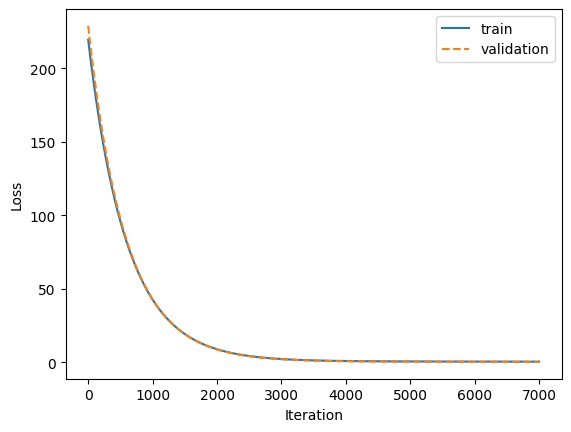

Training Validation MSE: (0.47988772340120806, 0.2889120065744369)


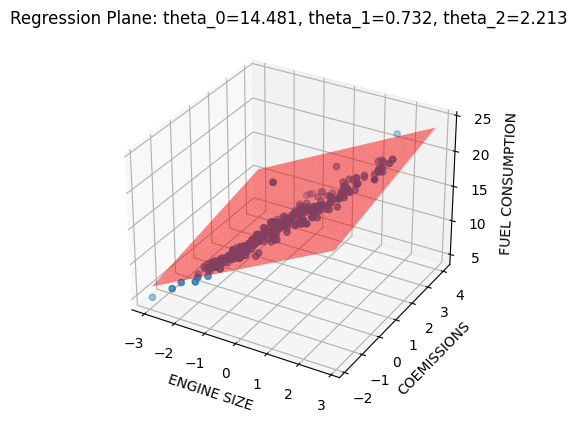

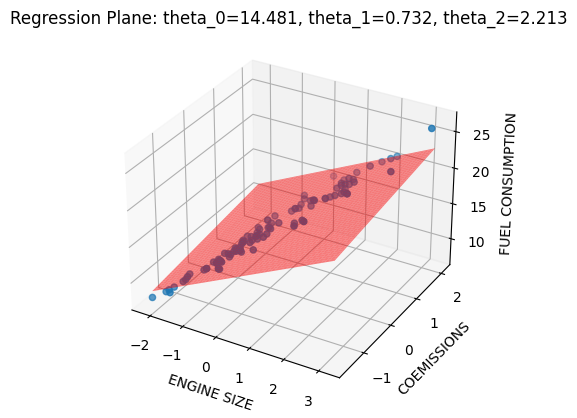

797.7177957186653


In [11]:
# implement regression model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

class LinearRegression:
    def __init__(self, alpha=0.0001, num_iterations=30):
        self.alpha = alpha
        self.num_iterations = num_iterations
        # theta is a vector of theta_0, theta_1 ... theta_n for n number of features
        self.theta = []
        self.cost_history = []

    def pred(self, X):
        # X is a single tuple, not an array of tuples
        return self.theta[0] + sum([self.theta[i+1]*X[i] for i in range(len(X))])

    def cost(self, X_data, Y_true):
        mse = 0
        for i in range(len(X_data)):
            mse += (self.pred(X_data.iloc[i]) - Y_true.iloc[i])**2
        # return mean of the squared errors
        return mse / len(X_data)

    def calc_grad(self,X,Y):
        # loss = sigma((y_n - (theta_0 + theta_1*x_n))^2)
        # taking partial derivatives of the loss function above with respect to theta_0 and theta_1
        grad_theta0 = sum([-2*(Y[i] - (self.theta[0] + sum([self.theta[k+1]*X.iloc[i][k] for k in range(X.shape[1])]))) for i in range(len(X))])
        self.theta[0] = self.theta[0] - self.alpha*grad_theta0
        for i in range(X.shape[1]):
            # gradcur_theta = sum([-2*(Y[i] - (self.theta_0 + self.theta_1*X[i])) for i in range(len(X))])
            # calculate the gradient of the loss function with respect to theta_{i+1}
            gradcur_theta = sum([-2*X.iloc[j][i]*(Y[j] - (self.theta[0] + sum([self.theta[k+1]*X.iloc[j][k] for k in range(X.shape[1])]))) for j in range(len(X))])
            self.theta[i+1] = self.theta[i+1] - self.alpha*gradcur_theta

    def fit(self, X_train, y_train,X_validation,y_validation):
        # create the theta vector with random initialization, of size dimensions(X)
        # self.theta.append(np.random.rand(1)[0])
        # for i in range(X.shape[1]):
        #     self.theta.append(np.random.rand(1)[0])
        # starting with zero gradients
        self.theta.append(0.0)
        for i in range(X.shape[1]):
            # self.theta.append(np.random.rand(1)[0])
            self.theta.append(0.0)

        for i in range(self.num_iterations):
            train_loss = self.cost(X_train, y_train)
            validation_loss = self.cost(X_validation,y_validation)
            self.cost_history.append((train_loss, validation_loss))
            self.calc_grad(X_train, y_train)

    def loss_plot(self):
        train_loss = [self.cost_history[i][0] for i in range(len(self.cost_history))]
        validation_loss = [self.cost_history[i][1] for i in range(len(self.cost_history))]
        plt.plot(train_loss,label='train')
        plt.plot(validation_loss, label='validation', linestyle='--')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plotline(self, X, Y):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X['COEMISSIONS '], X['ENGINE SIZE'], Y)
        x1 = np.linspace(X['COEMISSIONS '].min(), X['COEMISSIONS '].max(), 100)
        x2 = np.linspace(X['ENGINE SIZE'].min(), X['ENGINE SIZE'].max(), 100)
        x1, x2 = np.meshgrid(x1, x2)
        z = self.theta[0] + self.theta[1] * x2 + self.theta[2] * x1
        ax.plot_surface(x1, x2, z, color='red', alpha=0.5)
        ax.set_xlabel('ENGINE SIZE')
        ax.set_ylabel('COEMISSIONS')
        ax.set_zlabel('FUEL CONSUMPTION')
        plt.title(f'Regression Plane: theta_0={self.theta[0]:.3f}, theta_1={self.theta[1]:.3f}, theta_2={self.theta[2]:.3f}')
        plt.show()

    def predict(self,X):
        # TODO: ask if X is going to be a dataframe/list or a single feature vector
        predictions = [self.pred(x) for x in X]
        return predictions

# filtered the datafram to remove rows with missing engine size or fuel consumption values
df = df.sample(frac=1).reset_index(drop=True)

df = df.dropna(subset=['ENGINE SIZE', 'FUEL CONSUMPTION'])

# using engine size, coemissions and cylinders features
X = df[['ENGINE SIZE','COEMISSIONS ','CYLINDERS']]
y = df['FUEL CONSUMPTION']

# standardize the data
for i in range(X.shape[1]):
    mean = sum(X.iloc[:,i])/len(X.iloc[:,i])
    X.iloc[:,i] = (X.iloc[:,i] - mean)/np.std(X.iloc[:,i])
    # X.iloc[:,i] = X.iloc[:,i]/max(X.iloc[:,i])

X_train = X[:int(0.8*len(X))]
y_train = y[:int(0.8*len(y))]


X_validation = X[int(0.8*len(X)):]
y_validation = y[int(0.8*len(y)):]

print(len(X_train))
print(len(X_validation))


# linear_regressor = LinearRegression(alpha=0.000001, num_iterations=4000)
linear_regressor = LinearRegression(alpha=0.000001, num_iterations=7000)

linear_regressor.fit(X_train, y_train,X_validation,y_validation)

linear_regressor.loss_plot()

print("Training Validation MSE:",linear_regressor.cost_history[-1])

linear_regressor.plotline(X_train, y_train)
linear_regressor.plotline(X_validation, y_validation)

print(linear_regressor.pred(df.iloc[50][['ENGINE SIZE','COEMISSIONS ','CYLINDERS']]))

# with open('../models/regression_model1.pkl','wb') as f:
#     pickle.dump(linear_regressor,f)

# with open('../models/regression_model1.pkl', 'rb') as f:
#     linear_regressor_load = pickle.load(f)

# linear_regressor_load.plotline(X_train, y_train)